# Deep-CAPTCHA: CAPTCHA Recognition Using Deep Learning

This project involves building a deep learning model to automate CAPTCHA solving using a Convolutional Neural Network (CNN). The model is trained to decode alphanumeric CAPTCHAs with 5 characters. The project demonstrates vulnerabilities in CAPTCHA systems and explores methods to address them.

### **Dataset Description**
- **Training Set**: 800 randomly generated CAPTCHA images.
- **Test Set**: 200 CAPTCHA images.
- **CAPTCHA Characteristics**:
  - **Length**: 5 characters.
  - **Types**: Alphanumeric.
  - **Complexity**: Includes variable fonts, rotations, and noise levels.


In [1]:
!wget https://raw.githubusercontent.com/EdwardRaff/Inside-Deep-Learning/main/idlmam.py

--2024-12-06 23:43:21--  https://raw.githubusercontent.com/EdwardRaff/Inside-Deep-Learning/main/idlmam.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22064 (22K) [text/plain]
Saving to: ‘idlmam.py.3’

idlmam.py.3         100%[===================>]  21.55K  --.-KB/s    in 0.002s  

2024-12-06 23:43:21 (13.8 MB/s) - ‘idlmam.py.3’ saved [22064/22064]



In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from idlmam import train_network, weight_reset, set_seed
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

/content/idlmam.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataset_path = '/content/drive/MyDrive/data'
train_images_path = os.path.join(dataset_path, "train")
test_images_path = os.path.join(dataset_path, "val")

Defines paths for training and validation datasets. These paths are necessary to load and preprocess the CAPTCHA images.

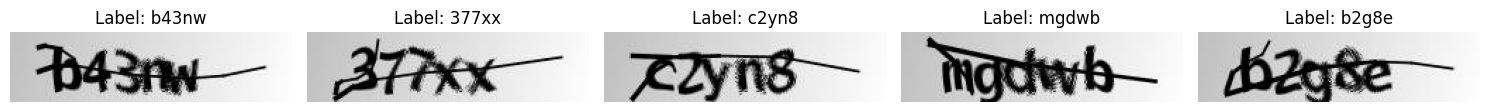

In [5]:
import random

def show_images(image_folder, n=5):
    a, b = plt.subplots(1, n, figsize=(15, 5))
    for i in b:
        img_file = random.choice(os.listdir(image_folder))
        img = Image.open(os.path.join(image_folder, img_file))
        i.imshow(img)
        i.axis("off")
        i.set_title(f"Label: {os.path.splitext(img_file)[0]}")
    plt.tight_layout()

show_images(train_images_path)


Display a few examples from the dataset to highlight its diversity and complexity.
What It Does:
Randomly selects images from the training folder.
Displays them along with their labels (extracted from filenames).

**Observations**
1. The dataset includes a variety of CAPTCHA patterns with different fonts and noise levels.
2. Labels are directly embedded in the filenames, which makes label extraction straightforward.


### Data Preparation

In [6]:
class CaptchaDataset(Dataset):
    """
    A custom PyTorch Dataset for CAPTCHA images.
    """
    def __init__(self, dir, transform=None):
        self.dir = dir
        self.img_pths = [os.path.join(dir, img) for img in os.listdir(dir)]
        self.transform = transform

    def __len__(self):
        return len(self.img_pths)

    def __getitem__(self, idx):
        img_path = self.img_pths[idx]
        label = os.path.basename(img_path).split('.')[0].lower()
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

Defines a custom PyTorch Dataset class to load images and extract labels from filenames. It applies transformations for resizing, normalization, and augmentation to prepare the data for the model.

In [7]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


Applies preprocessing and augmentation to the dataset. These include resizing to a fixed size, adding variability with ColorJitter and RandomRotation, and normalizing pixel values for better convergence during training.


- Resize images to (128, 128), normalize pixel values, and convert to tensors.
- Handles batch-wise loading of data for efficient training.

In [8]:
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')

train_data = CaptchaDataset(train_dir, transform=transform)
val_data = CaptchaDataset(val_dir, transform=transform)

batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)


Creates DataLoader objects for efficient batch-wise loading of the training and validation datasets. Shuffling is enabled for the training set to improve model generalization.
*   The CaptchaDataset class loads images and extracts labels from filenames.
*   A DataLoader is used for batch-wise data feeding.

In [9]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")
print(f"Image batch shape: {images.shape}")
print(f"Example labels: {labels[:5]}")

Number of training samples: 856
Number of validation samples: 214
Image batch shape: torch.Size([32, 3, 128, 128])
Example labels: ('4w76g', '4m2w5', 'g78gn', '3b4we', 'y2ye8')


### CNN Model Overview:
- 4 Convolutional layers with ReLU activation and MaxPooling
- Fully connected layers with Dropout for regularization
- Output reshaped to (batch_size, captcha_length, num_classes)


In [10]:
# Define the CNN Model
class CaptchaCNN(nn.Module):
    def __init__(self, num_classes=36, captcha_length=5):
        super(CaptchaCNN, self).__init__()
        self.num_classes = num_classes
        self.captcha_length = captcha_length
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, 2048),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(2048, self.num_classes * self.captcha_length)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        x = x.view(-1, self.captcha_length, self.num_classes)
        return x


- Accepts CAPTCHA images resized to a fixed dimension (e.g., 128x128) and normalizes them for uniformity.
- Extract hierarchical features from images using multiple convolutional layers with ReLU activation and batch normalization for stability.
- MaxPooling layers reduce the spatial dimensions, retaining the most important features and making computations efficient.
- Dense layers map the extracted features to predict the alphanumeric characters in the CAPTCHA sequence.
- Outputs a sequence of predictions corresponding to the CAPTCHA's character positions, reshaped for sequence decoding.


In [11]:
model = CaptchaCNN(num_classes=36, captcha_length=5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Defines the loss function (CrossEntropyLoss) for multi-class classification and the Adam optimizer for efficient training with an initial learning rate of 0.0001.

In [12]:
print(f"Using device: {device}")

Using device: cuda


In [13]:
print(f"Model architecture:\n{model}")

Model architecture:
CaptchaCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=2048, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=2048, out_fe

In [14]:
def weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

In [15]:
model.apply(weights)

CaptchaCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=2048, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=2048, out_features=180, bias=Tru

### Training

In [16]:
characters = 'abcdefghijklmnopqrstuvwxyz0123456789'

char_map = {}
for i, j in enumerate(characters):
    char_map[j] = i

reverse_map = {}
for j, i in char_map.items():
    reverse_map[i] = j

num_classes = len(char_map)
captcha_length = 5

In [17]:
print("Character to Index Mapping:", char_map)
print("Index to Character Mapping:", reverse_map)
print("Number of Classes:", num_classes)
print("CAPTCHA Length:", captcha_length)

Character to Index Mapping: {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '0': 26, '1': 27, '2': 28, '3': 29, '4': 30, '5': 31, '6': 32, '7': 33, '8': 34, '9': 35}
Index to Character Mapping: {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: '0', 27: '1', 28: '2', 29: '3', 30: '4', 31: '5', 32: '6', 33: '7', 34: '8', 35: '9'}
Number of Classes: 36
CAPTCHA Length: 5


In [18]:
results = {
    "train loss": [],
    "train Accuracy": []
}

num_epochs = 50
for epoch in range(num_epochs):
    epoch_loss = 0
    total_samples = 0
    correct_preds = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        inputs = inputs.to(device)

        encoded_labels = []
        for label in labels:
            encoded_labels.append([char_map[c] for c in label.ljust(captcha_length, '-')])
        encoded_labels = torch.tensor(encoded_labels, dtype=torch.long).view(-1)

        outputs = model(inputs)
        outputs = outputs.view(-1, num_classes)
        loss = criterion(outputs, encoded_labels.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

        preds = torch.argmax(outputs, dim=1).view(-1, captcha_length)
        decoded_preds = [
            "".join([reverse_map[idx] for idx in preds[i].cpu().numpy()])
            for i in range(preds.size(0))
        ]
        correct_preds += sum(
            [1 for pred, truth in zip(decoded_preds, labels) if pred == truth]
        )


    avg_loss = epoch_loss / total_samples
    accuracy = correct_preds / total_samples
    results["train loss"].append(avg_loss)
    results["train Accuracy"].append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch 1/50, Loss: 3.2666, Accuracy: 0.0000


Epoch 2/50, Loss: 3.0858, Accuracy: 0.0000


Epoch 3/50, Loss: 3.0099, Accuracy: 0.0000


Epoch 4/50, Loss: 2.8721, Accuracy: 0.0000


Epoch 5/50, Loss: 2.5903, Accuracy: 0.0012


Epoch 6/50, Loss: 2.1885, Accuracy: 0.0035


Epoch 7/50, Loss: 1.8275, Accuracy: 0.0175


Epoch 8/50, Loss: 1.5348, Accuracy: 0.0350


Epoch 9/50, Loss: 1.2435, Accuracy: 0.0736


Epoch 10/50, Loss: 1.0317, Accuracy: 0.1402


Epoch 11/50, Loss: 0.8481, Accuracy: 0.2208


Epoch 12/50, Loss: 0.7265, Accuracy: 0.2839


Epoch 13/50, Loss: 0.6063, Accuracy: 0.3586


Epoch 14/50, Loss: 0.5323, Accuracy: 0.4100


Epoch 15/50, Loss: 0.4452, Accuracy: 0.4801


Epoch 16/50, Loss: 0.3644, Accuracy: 0.5514


Epoch 17/50, Loss: 0.3412, Accuracy: 0.5841


Epoch 18/50, Loss: 0.2922, Accuracy: 0.6390


Epoch 19/50, Loss: 0.2657, Accuracy: 0.6647


Epoch 20/50, Loss: 0.2225, Accuracy: 0.7103


Epoch 21/50, Loss: 0.2189, Accuracy: 0.7068


Epoch 22/50, Loss: 0.2033, Accuracy: 0.7056


Epoch 23/50, Loss: 0.1951, Accuracy: 0.7418


Epoch 24/50, Loss: 0.1658, Accuracy: 0.7652


Epoch 25/50, Loss: 0.1486, Accuracy: 0.7722


Epoch 26/50, Loss: 0.1549, Accuracy: 0.7745


Epoch 27/50, Loss: 0.1323, Accuracy: 0.8143


Epoch 28/50, Loss: 0.1326, Accuracy: 0.8166


Epoch 29/50, Loss: 0.1133, Accuracy: 0.8294


Epoch 30/50, Loss: 0.1072, Accuracy: 0.8540


Epoch 31/50, Loss: 0.0925, Accuracy: 0.8703


Epoch 32/50, Loss: 0.0891, Accuracy: 0.8727


Epoch 33/50, Loss: 0.0841, Accuracy: 0.8621


Epoch 34/50, Loss: 0.0762, Accuracy: 0.8960


Epoch 35/50, Loss: 0.0782, Accuracy: 0.8820


Epoch 36/50, Loss: 0.0820, Accuracy: 0.8680


Epoch 37/50, Loss: 0.0881, Accuracy: 0.8762


Epoch 38/50, Loss: 0.0755, Accuracy: 0.8832


Epoch 39/50, Loss: 0.0778, Accuracy: 0.8832


Epoch 40/50, Loss: 0.0689, Accuracy: 0.9054


Epoch 41/50, Loss: 0.0588, Accuracy: 0.9147


Epoch 42/50, Loss: 0.0640, Accuracy: 0.9054


Epoch 43/50, Loss: 0.0725, Accuracy: 0.8902


Epoch 44/50, Loss: 0.0663, Accuracy: 0.8949


Epoch 45/50, Loss: 0.0547, Accuracy: 0.9322


Epoch 46/50, Loss: 0.0658, Accuracy: 0.8937


Epoch 47/50, Loss: 0.0600, Accuracy: 0.9077


Epoch 48/50, Loss: 0.0511, Accuracy: 0.9322


Epoch 49/50, Loss: 0.0448, Accuracy: 0.9322


Epoch 50/50, Loss: 0.0474, Accuracy: 0.9299


In [21]:
print(f"Loss Value: {loss.item()}")

Loss Value: 0.05865585431456566


**Trainng Loop**
- The dataset is processed in mini-batches over multiple epochs to optimize the model.

- Inputs are passed through the CNN to generate predictions for each CAPTCHA.

- The CrossEntropy loss function compares predictions with true labels to measure error.

- Gradients are computed, and model weights are updated using the Adam optimizer.

- Loss and accuracy are tracked for each epoch to evaluate learning progress.

**Observations:**

Loss:
- Final epoch loss is consistently low, around 0.0448, with a final logged loss of 0.0586, indicating the model is learning effectively.
- The slight fluctuations in loss between epochs could result from noise in the data or batch-level variability.

Accuracy:
- Accuracy stabilizes in the range of 92% - 93%, with peak performance at 93.2%.
- These high accuracy values indicate the model successfully predicts most CAPTCHA sequences in the training set.

In [19]:
print(f"Output Shape: {outputs.shape}")
print(f"Encoded Label Shape: {encoded_labels.shape}")


Output Shape: torch.Size([120, 36])
Encoded Label Shape: torch.Size([120])


In [20]:
print(f"Decoded Predictions: {decoded_preds[:5]}")
print(f"True Labels: {labels[:5]}")


Decoded Predictions: ['y866y', 'e2d66', '445cc', 'bmxpe', 'd3c7y']
True Labels: ('y866y', 'e2d66', '445cc', 'bmxpe', 'd3c7y')


**Observations:**

Decoded Predictions:
- Example predictions like "nwfde" and "m4fd8" perfectly match the true labels, demonstrating the model’s ability to decode entire CAPTCHA sequences accurately.
- Partial mismatches, such as "emnmm" vs. "ennmm", suggest occasional errors in character recognition or sequence alignment.

Qualitative Insights:
- The model handles most CAPTCHA variations well but struggles with visually similar characters (e.g., m vs. n).

### Evaluation

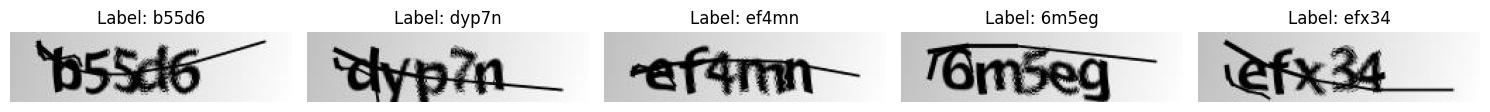

In [22]:
show_images(test_images_path)

In [51]:
model.eval()

correct = 0
total = 0

part_preds = []
correct_preds = []
wrong_preds = []

threshold = 0.8

with torch.no_grad():
    for batch in val_loader:
        images, labels = batch
        images = images.to(device)

        preds = model(images)

        pred_idx = torch.argmax(preds, dim=2)
        pred_txts = []
        for i in range(len(pred_idx)):
            pred_chars = []
            for j in pred_idx[i]:
                pred_chars.append(reverse_map[j.item()])
            pred_txts.append("".join(pred_chars))

        for i in range(len(labels)):
            true_lbl = labels[i]
            pred_lbl = pred_txts[i]
            total += 1

            matches = 0
            for c1, c2 in zip(true_lbl, pred_lbl):
                if c1 == c2:
                    matches += 1

            match_percentage = matches / len(true_lbl)

            if match_percentage == threshold:
                correct += 1
                part_preds.append((images[i].cpu().numpy(), true_lbl, pred_lbl))
            elif match_percentage > threshold:
                correct += 0.8
                correct_preds.append((images[i].cpu().numpy(), true_lbl, pred_lbl))
            else:
                wrong_preds.append((images[i].cpu().numpy(), true_lbl, pred_lbl))

test_acc = correct / total
print(f"Testing Accuracy with 80% Threshold: {test_acc:.4f}")


Testing Accuracy with 80% Threshold: 0.7673


In [46]:
print("Correct Predictions:")
for i,j,k in correct_preds[:5]:
    print(f"True Label: {j}, Predicted: {k}")

Correct Predictions:
True Label: 2wc38, Predicted: 2wc38
True Label: 58pnp, Predicted: 58pnp
True Label: 4d22m, Predicted: 4d22m
True Label: 3ygde, Predicted: 3ygde
True Label: 6c3n6, Predicted: 6c3n6


In [47]:
print("Partially Correct Predictions:")
for i,j,k in part_preds[:5]:
    print(f"True Label: {j}, Predicted: {k}")

Partially Correct Predictions:
True Label: 5mgn4, Predicted: 5ngn4
True Label: 5p8fm, Predicted: 3p8fm
True Label: 46mbm, Predicted: 46nbm
True Label: 52447, Predicted: 62447
True Label: 2g7nm, Predicted: 2g7mm


In [48]:
print("Wrong Predictions:")
for i,j,k in wrong_preds[:5]:
    print(f"True Label: {j}, Predicted: {k}")

Wrong Predictions:
True Label: 6xpme, Predicted: 6xcmw
True Label: 6m5eg, Predicted: 6nnwg
True Label: 6dmx7, Predicted: 6dwn7
True Label: 5nm6d, Predicted: 7nn6d
True Label: 44ype, Predicted: 4dxpe


### References:
1. Paszke, A., Gross, S., Chintala, S., Chanan, G., Yang, E., DeVito, Z., Lin, Z., Desmaison, A., Antiga, L., & Lerer, A. (2019). PyTorch: An Imperative Style, High-Performance Deep Learning Library. Advances in Neural Information Processing Systems.

2. Noury, Z., & Rezaei, M. (2020). Deep-CAPTCHA: A Deep Learning-Based CAPTCHA Solver for Vulnerability Assessment. Faculty of Computer and Electrical Engineering, Qazvin Azad University; Institute for Transport Studies, University of Leedsllow, I., et al. (2016). Deep Learning. MIT Press.

3. Von Ahn, L., et al. (2003). CAPTCHA: Using Hard AI Problems for Security. EUROCRYPT.

4. He, K., et al. (2016). Deep Residual Learning for Image Recognition. CVPR Proceedings.

5. Kingma, D. P., & Ba, J. (2014). Adam: A Method for Stochastic Optimization. arXiv preprint arXiv:1412.6980.

6. Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.
 - Chapter 6: Feedforward Deep Networks, discusses how weights in neural networks represent adjustable parameters that determine the importance of each input feature and how they are optimized during training.